# Tilt and Compliance Corrections for OBS Data
### Xiaotao Yang @ Harvard University April 2020
This notebook contains examples of compliance corrections using data downloaded from IRIS. The functions for tilt and compliance corrections are saved in a separate file: TCcorrection_funcs.py.

## Step-1. Load needed packages.
Some functions are imported from the utilities.py and the TCcorrection_funcs.py.

In [1]:
#import needed packages.
from collections import OrderedDict
from utilities import sta_info_from_inv,plot_trace,segment_interpolate
from TCcorrection_funcs import docorrection,gettransfer, maxcompfreq
import sys
import time
import scipy
import obspy
import pyasdf
import datetime
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from IPython.display import clear_output

## Step-2. Setting global parameters for downloading and conducting corrections.
We use the same day as Bell et al. (BSSA, 2015). Station 7D.J35A was used by their example in removing compliance noise. The following figure is from their paper for reference.

![title](Bell2015Fig9.png)

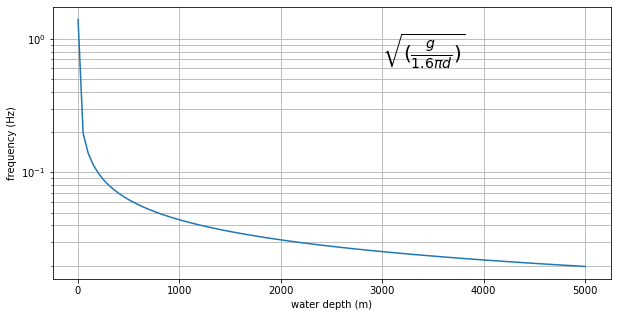

In [2]:
# get data from IRIS web service
client    = Client('IRIS')
netlist="7D"
stalist=["J35A"]#["G03A","J35A","J44A","J65A"]
Pchanlist=["HDH","BDH"] #pressure channels
starttime = obspy.UTCDateTime("2012_01_21_0_0_0")       
endtime   = obspy.UTCDateTime("2012_01_22_0_0_0")
stlamin,stlamax,stlomin,stlomax= 37.0,52.0,-133.0,-116.0
rmresp=True #remove instrument response
rmrespoutput="DISP"
# parameters for butterworth filter
samp_freq=20
pfreqmin=0.001
pfreqmax=samp_freq/2

# prefilter information used when removing instrument responses
f1 = 0.9*pfreqmin;f2=pfreqmin
if 1.1*pfreqmax > 0.45*samp_freq:
    f3 = 0.4*samp_freq
    f4 = 0.45*samp_freq
else:
    f3 = pfreqmax
    f4= 1.1*pfreqmax
pre_filt  = [f1,f2,f3,f4]

# get relationship between water depth and maximum compliance frequency.
d=np.arange(1,5051,50) #water depth
f=maxcompfreq(d,iplot=True)

## Step-3. Start downloading and running correction codes.
I skip removing instrument response for the pressure channel, since ObsPy doesn't handle PA as the output unit. The source code, however, contains the consideration of PRESSURE (https://docs.obspy.org/_modules/obspy/core/inventory/response.html). I am still figuring out which way is correct.


pressure channel BDH
vertical channel BHZ
resampling from 50 to 20
removing response for 7D.J35A..BDH | 2012-01-21T00:00:00.000000Z - 2012-01-21T23:59:59.950000Z | 20.0 Hz, 1728000 samples using inv
removing response for 7D.J35A..BHZ | 2012-01-21T00:00:00.000000Z - 2012-01-21T23:59:59.950000Z | 20.0 Hz, 1728000 samples using inv
getting transfer function ...


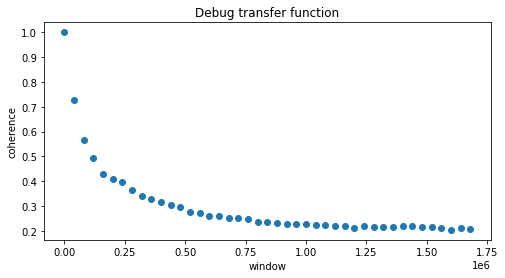

doing correction ...


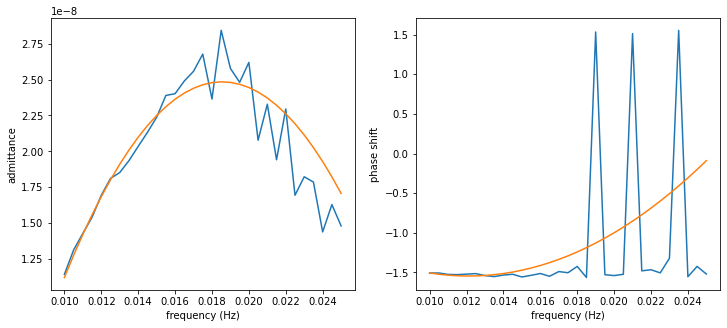

plotting ...
station 7D.J35A, filtered at [ 0.010,  0.025]
station 7D.J35A, filtered at [ 0.010,  0.025]
station 7D.J35A, filtered at [ 0.010,  0.025]
station 7D.J35A, filtered at [ 0.010,  0.025]


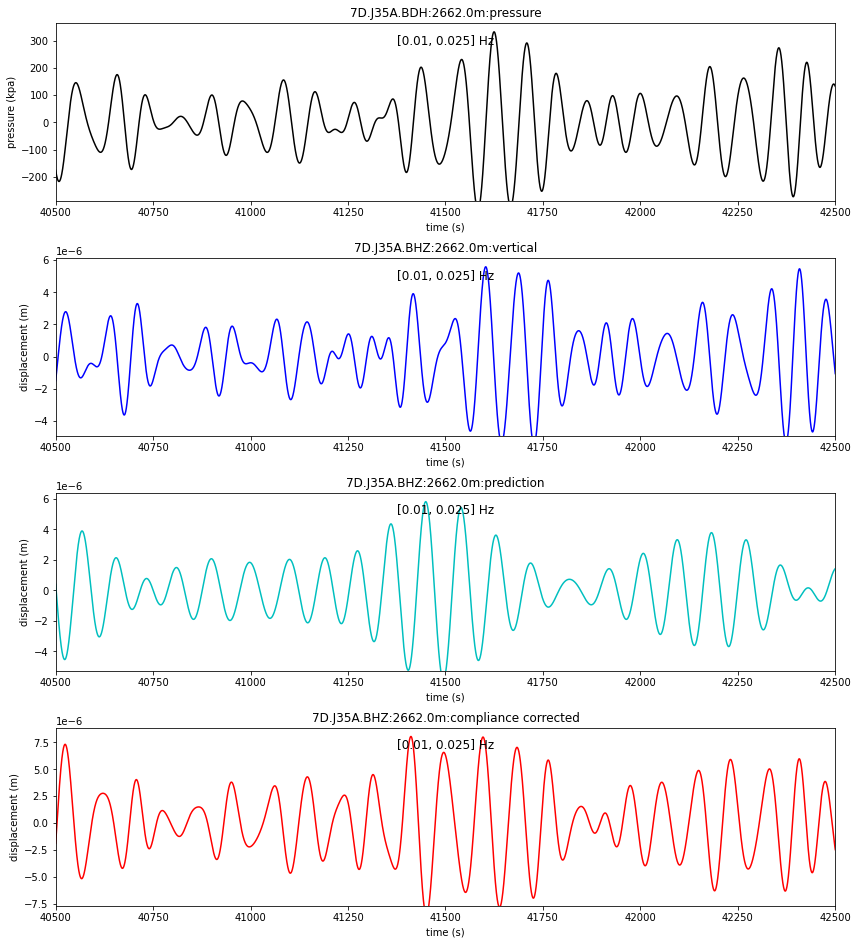

station 7D.J35A, filtered at [ 0.010,  0.025]
station 7D.J35A, filtered at [ 0.010,  0.025]
station 7D.J35A, filtered at [ 0.010,  0.025]


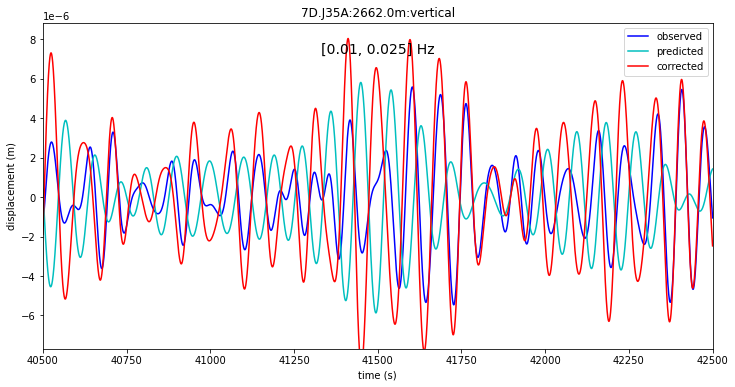

In [4]:
for ista in stalist:
    clear_output(wait=True)
    trall=[] 
    stinv=[]
    trlabels=[]
    """
    array to save all four set of traces: 0-pressure, 1-vertical, 2-prediction of vertical from pressure,
    3-corrected vertical
    """
    
    #download pressure data first
    pchanfound=0
    for chan in Pchanlist:
        try:
            sta_invP = client.get_stations(network=netlist,station=ista,channel=chan,location='*', \
                            starttime=starttime,endtime=endtime,minlatitude=stlamin,maxlatitude=stlamax, \
                            minlongitude=stlomin, maxlongitude=stlomax,level='response')
            print()
            pchan=chan
            pchanfound=1
            sta,net,lon,lat,elv,location=sta_info_from_inv(sta_invP)
            
            break
        except Exception as e:
            pchanfound == 0
            
    if pchanfound == 0 and chan == Pchanlist[-1]:
        print("Pressure channels not found for "+net+"."+ista)
        continue

    stinv.append(sta_invP)
    trlabels.append(net+"."+ista+"."+pchan+":"+str(np.abs(elv))+"m:pressure")
    tr=client.get_waveforms(network=net,station=ista,\
                    channel=pchan,location="*",starttime=starttime,endtime=endtime)
    tr[0].detrend()
    trall.append(tr[0])
    print("pressure channel "+pchan)

    #download vertical data now
    zchan=pchan[0]+"HZ"

    sta_invZ = client.get_stations(network=net,station=ista,channel=zchan,location='*', \
                    starttime=starttime,endtime=endtime,minlatitude=stlamin,maxlatitude=stlamax, \
                    minlongitude=stlomin, maxlongitude=stlomax,level='response')

    stinv.append(sta_invZ)
    trlabels.append(net+"."+ista+"."+zchan+":"+str(np.abs(elv))+"m:vertical")
    tr=client.get_waveforms(network=net,station=ista,\
                    channel=zchan,location="*",starttime=starttime,endtime=endtime)
    tr[0].detrend()
    trall.append(tr[0])
    print("vertical channel "+zchan)

    sps=int(trall[0].stats.sampling_rate) #assume pressure and vertical channels have the same sampling rat
    # make downsampling if needed
    if sps > samp_freq:
        # downsampling here
        print("resampling from "+str(sps)+" to "+str(samp_freq))
        for it in range(len(trall)):
            trall[it].interpolate(samp_freq,method='weighted_average_slopes')
            delta = trall[it].stats.delta

            # when starttimes are between sampling points
            fric = trall[it].stats.starttime.microsecond%(delta*1E6)
            if fric>1E-4:
                trall[it].data = segment_interpolate(np.float32(trall[it].data),float(fric/(delta*1E6)))
                #--reset the time to remove the discrepancy---
                trall[it].stats.starttime-=(fric*1E-6)

    #remove response from the two downloaded channels
    if rmresp:
        for it in range(len(trall)):
#             if it == 0: continue #skip pressure channel
            if not stinv[it][0][0][0].response:
                raise ValueError('no response found in the inventory! abort!')
            else:
                try:
                    print('removing response for %s using inv'%trall[it])
                    trall[it].attach_response(stinv[it])
#                     trall[it].remove_response(pre_filt=pre_filt,water_level=60)
#                     if it == 0: #:continue #skip pressure channel
#                         trall[it].remove_response(output='PRESSURE',pre_filt=pre_filt,water_level=60)
#                     else:
                    trall[it].remove_response(output=rmrespoutput,pre_filt=pre_filt,water_level=60)
                except Exception as e:
                    print(e)
                    trall[it] = []
           
    #start compliance correction
    #get the transfer function
#     freqmin=pfreqmin
#     freqmax=np.around(maxcompfreq(np.abs(elv)),decimals=3)
    freqmin=0.01
    freqmax=0.025
#     freqmin=0.02
#     freqmax=0.1
    delta=1.0/samp_freq
    print("getting transfer function ...")
#     trall[0].data=1000*trall[0].data #change from kpa to pa
    ff,coh,adm,phs,adm_err,phs_err = gettransfer(trall[0].data,trall[1].data,\
                                                 delta,iplot=True,winlen=2000,\
                                                figname=net+"."+ista+"."+pchan+"-"+zchan+"_debug_transfer.png")
    # do correction now.
    print("doing correction ...")
    trZ_pred,trZ_left = docorrection(trall[0],trall[1],adm,adm_err,phs,phs_err,\
                                     freqmin,freqmax,ff,iplot=1)

    trall.append(trZ_pred)
    trlabels.append(net+"."+ista+"."+zchan+":"+str(np.abs(elv))+"m:prediction")
    trall.append(trZ_left)
    trlabels.append(net+"."+ista+"."+zchan+":"+str(np.abs(elv))+"m:compliance corrected")
    
    #plotting
    print("plotting ...")
#     tmin=np.max([trall[0].times()[0],trall[1].times()[0]])
#     tmax=np.min([trall[0].times()[-1],trall[1].times()[-1]])
    tmin=40500
    tmax=42500
#     tmin=0
#     tmax=3600*24
    tlen=tmax-tmin
    if tlen>3600:tlen=3600 #only plot 1 hour now
        
    plot_trace(trall,size=(12,13),title=trlabels,freqmin=freqmin,freqmax=freqmax,\
               xlimit=(tmin,tmin+tlen),subplotpar=(4,1),\
               ylabels=["pressure (kpa)","displacement (m)","displacement (m)","displacement (m)"],\
               outfile=net+"."+ista+"_correction.png",spacing=1,colors=['k','b','c','r'])
    plot_trace((trall[1],trall[2],trall[3]),size=(12,6),datalabels=["observed","predicted","corrected"],\
               title=net+"."+ista+":"+str(np.abs(elv))+"m:vertical",freqmin=freqmin,freqmax=freqmax,xlimit=(tmin,tmin+tlen),mode="overlap",\
               ylabels=["displacement (m)"],outfile=net+"."+ista+"_comparison.png",colors=['b','c','r'])



In [ ]:
trtemp=client.get_waveforms(network=net,station=ista,\
                channel=pchan,location="*",starttime=starttime,endtime=endtime)
trtemp[0].detrend()

station 7D.J49A, filtered at [ 0.020,  0.100]


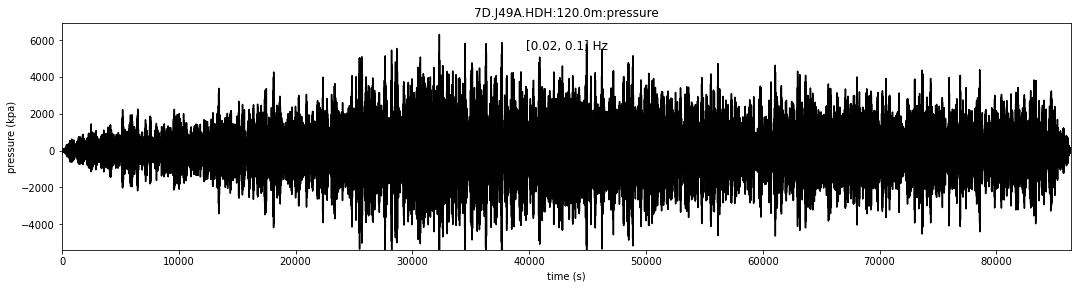

In [21]:
freqmin=0.02
freqmax=0.1
tr=trtemp[0].copy()
tr.remove_response(inventory=sta_invP,output='VEL',pre_filt=pre_filt,water_level=60)
plot_trace([tr],size=(15,4),title=trlabels,freqmin=freqmin,freqmax=freqmax,\
           subplotpar=(1,1),\
           ylabels=["pressure (kpa)","displacement (m)","displacement (m)","displacement (m)"],\
           outfile=net+"."+ista+"_correction.png",spacing=2,colors=['k','b','c','r'])

In [29]:
tr.stats['sac']={'dist':100}
tr.write('test.sac',format='SAC')

In [26]:
tr.stats

               network: 7D
               station: J49A
              location: 
               channel: HDH
             starttime: 2012-03-04T00:00:00.006500Z
               endtime: 2012-03-04T23:59:59.998500Z
         sampling_rate: 125.0
                 delta: 0.008
                  npts: 10800000
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 4379, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 17936384})
            processing: ['ObsPy 1.2.1: trim(endtime=UTCDateTime(2012, 3, 4, 23, 59, 59, 998500)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2012, 3, 3, 23, 59, 59, 998500))', "ObsPy 1.2.1: detrend(options={}::type='simple')", "ObsPy 1.2.1: remove_response(fig=None::inventory=<obspy.core.inventory.inventory.Inventory object at 0x12c310dd0>::output='VEL'::plot=Fals